# Домашнее задание

Анна Кондратьева, БКЛ 153

Выбранное сообщество - https://vk.com/eurovisionsongcontest

### Примечание:
Здесь нет графиков "длина поста - город" и "длина поста - возраст", потому что в выбранном мной сообществе все посты публикуются от имени группы. Но так как это делается абсолютно аналогично графикам "длина коммента - город/возраст", я надеюсь, что их будет достаточно.

In [229]:
%matplotlib inline
import requests
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
from matplotlib import style
style.use('ggplot') 

In [230]:
def vk_api(method, **kwargs):
    api_request = 'https://api.vk.com/method/'+method + '?'
    api_request += '&'.join(['{}={}'.format(key, kwargs[key]) for key in kwargs])
    return json.loads(requests.get(api_request).text)

In [231]:
def count_words(elem):
    i = 0
    text = elem['text']
    text = re.sub('\n+', ' ', text)
    text = re.sub('\[id.*?\]', ' ', text).split()
    
    while i < len(text):
        m = re.search ('[a-z]+|[а-я]+|[0-9]+', text[i], flags = re.IGNORECASE)
        
        if m == None:
            text.pop(i)
        else:
            i += 1
    
    text_len = len(text)
    
    return text_len

In [232]:
def get_group_id():
    group_info = vk_api('groups.getById', group_id='eurovisionsongcontest', v='5.63')
    group_id = group_info['response'][0]['id']
    
    return group_id

In [233]:
def download_posts(group_id):
    posts = []
    item_count = 200

    result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100)
    posts += result['response']['items']

    while len(posts) < item_count:
        result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100, offset=len(posts))
        posts += result['response']['items']
        
    return posts

In [234]:
def save_texts(texts, filename):
    with open (filename, 'w', encoding = 'utf-8') as file:
        file.write('text, user_id, len\n')
        for elem in texts:
            file.write('%s,%s,%s\n' % (elem['text'], elem['from_id'], count_words(elem)))

In [235]:
def download_comments(posts, group_id):
    comments = []

    for post in posts:
        post_comments = []
        item_count = post['comments']['count']

        result = vk_api('wall.getComments', owner_id=-group_id, post_id = post['id'])
        post_comments += result['response']

        while len(post_comments) < item_count:
            result = vk_api('wall.getComments', owner_id=-group_id, post_id = post['id'], count=100, offset=len(post_comments))
            post_comments += result['response']

        for elem in post_comments:
            if type(elem) != dict:
                post_comments.remove(elem)

        comments.append(post_comments)
        
    return comments

In [236]:
def first_graph_info(posts, comments):
    post_words = []
    comment_words = []

    for i in range (len(posts)):
        comm_len = []
        post_words.append(count_words(posts[i]))

        for j in range (len(comments[i])):
            comm_len.append(count_words(comments[i][j]))

        mean_len = np.array(comm_len).mean()

        comment_words.append(mean_len)
        
    return post_words, comment_words

In [237]:
def count_age(birthday):
    today = date.today()
    birthday = datetime.strptime(birthday, '%d.%m.%Y')
    age = today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))
    
    return age

In [238]:
def append_info(dicty, elem, text_len):
    if elem in dicty.keys():
        dicty[elem].append(text_len)
    else:
        dicty[elem] = []
        dicty[elem].append(text_len)
        
    return dicty

In [239]:
def get_info(post):

    cities = {}
    ages = {}

    for elem in post:
        text_len = count_words(elem)
        user_id = abs(elem['from_id'])
        user_info = vk_api('users.get', user_ids=user_id, fields='bdate, city', v='5.63')['response'][0]
       
        if 'city' in user_info.keys():
            city = user_info['city']['title']
            cities = append_info(cities, city, text_len)
        
        if 'bdate' in user_info.keys():
            if re.search('[0-9]{4}', user_info['bdate']):
                age = count_age(user_info['bdate'])
                ages = append_info(ages, age, text_len)
        
    return cities, ages

In [240]:
def find_mean_length(dicty):
    for key, value in dicty.items():
        new_value = np.array(value).mean()
        dicty[key] = new_value
        
    return dicty

In [241]:
def draw_first_graph(x_info, y_info, x_label, y_label):
    plt.figure(figsize=(20,10))
    plt.bar(x_info, y_info)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [242]:
def draw_second_graph(dicty, x_label, y_label):
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dicty)), [value for value in dicty.values()])
    plt.xticks(range(len(dicty)), [key for key in dicty.keys()], rotation='vertical')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [243]:
group_id = get_group_id()
posts = download_posts(group_id)
comments = download_comments(posts, group_id)
post_words, comment_words = first_graph_info(posts, comments)

In [244]:
all_comments = []

for post in comments:
    all_comments += post
    
save_texts(posts, 'posts.csv')
save_texts(all_comments, 'comments.csv')

comment_cities, comment_ages = get_info(all_comments)

comment_cities = find_mean_length(comment_cities)
comment_ages = find_mean_length(comment_ages)

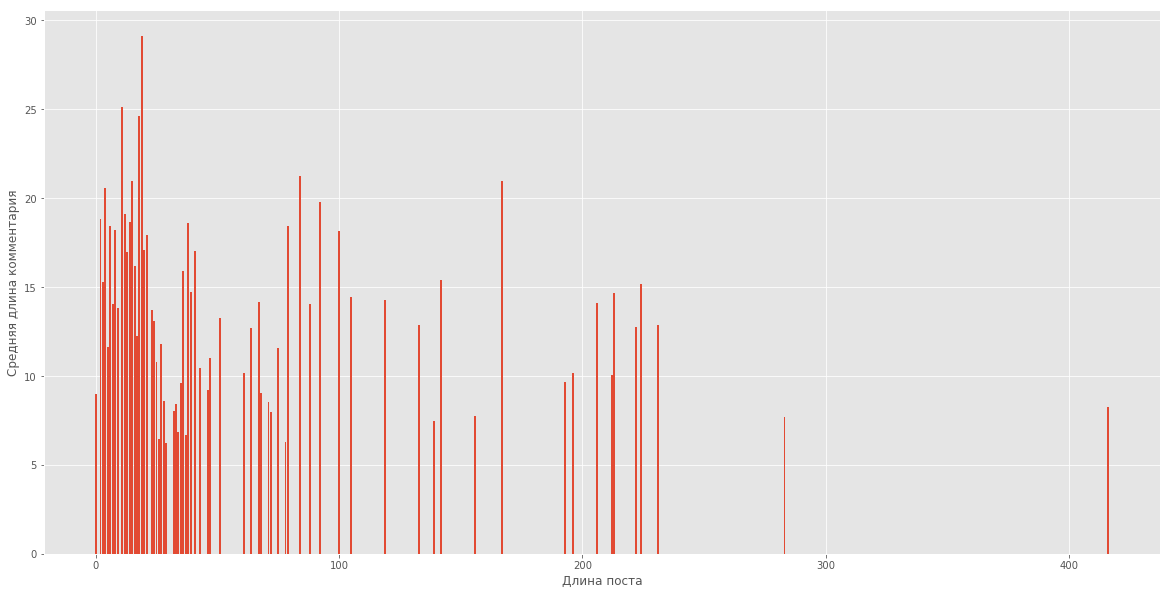

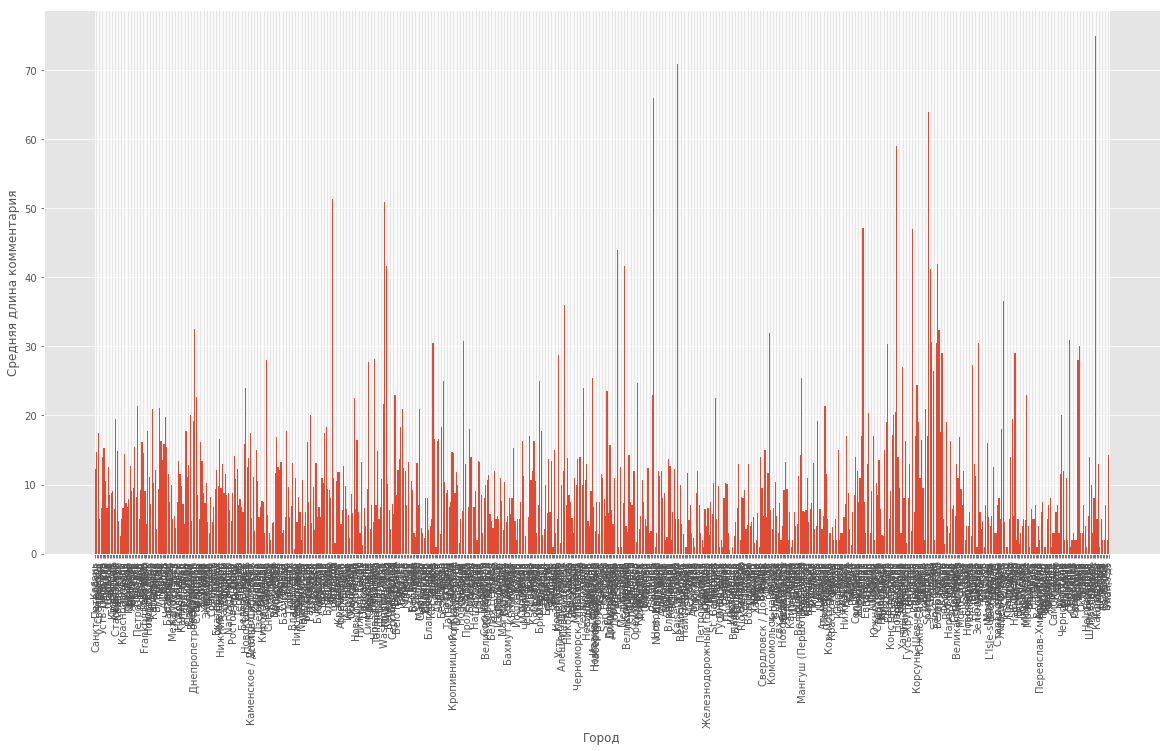

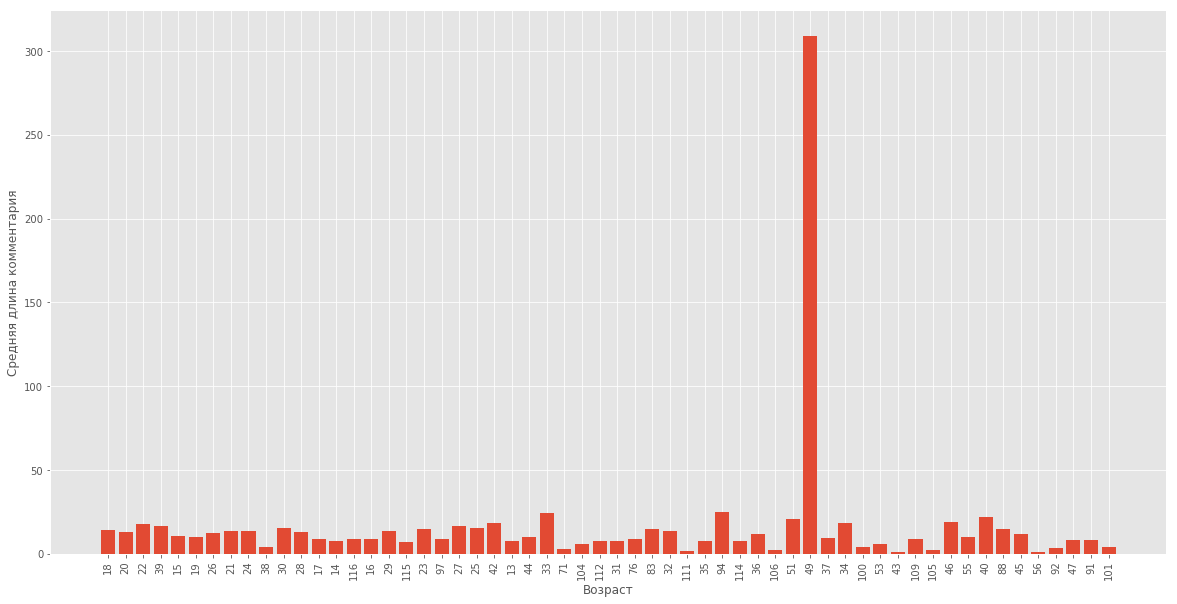

In [245]:
draw_first_graph(post_words, comment_words, 'Длина поста', 'Средняя длина комментария')
draw_second_graph(comment_cities, 'Город', 'Средняя длина комментария')
draw_second_graph(comment_ages, 'Возраст', 'Средняя длина комментария')